# CSCI 113i Final Project
Cheng, Montemayor, Shu Too - CSCI 113i J

## Data Pre-Processing and Visualization
We first import the pertinent libraries and our dataset.

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("e-shop clothing 2008.csv", sep = ";")

# Extra copy
copy = df.copy()

df

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165469,2008,8,13,1,29,24024,2,B10,2,4,1,67,1,1
165470,2008,8,13,1,9,24025,1,A11,3,4,1,62,1,1
165471,2008,8,13,1,34,24026,1,A2,3,1,1,43,2,1
165472,2008,8,13,2,34,24026,3,C2,12,1,1,43,1,1


We first rename the columns for additional context, using the `e-shop clothing 2008 data description.txt` file as a guide.

In [4]:
df.rename(columns = {
    'session ID' : 'session_id',
    'page 1 (main category)' : 'main_category',
    'page 2 (clothing model)' : 'product_code',
    'model photography' : 'model',
    'price 2' : 'higher_avgprice'},
    inplace = True)

First, we drop the `order` and `session_id` columns as they will not be used in this study.

In [5]:
df.drop(['order', 'session_id'], axis = 1, inplace = True)

Next, we aim to check for seasonality by combining the `year`, `month`, and `day` columns into a DateTime format. If seasonality is found, it may be possible to convert this information into a categorical variable.

In [6]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.drop(['year', 'month', 'day'], axis = 1, inplace = True)

In [7]:
dfdate_revenue = df.groupby('date')['price'].sum()
dfdate_revenue

date
2008-04-01    139570
2008-04-02    150387
2008-04-03     81466
2008-04-04     78843
2008-04-05     66579
               ...  
2008-08-09     47262
2008-08-10     40799
2008-08-11     54065
2008-08-12     60768
2008-08-13      8560
Name: price, Length: 135, dtype: int64

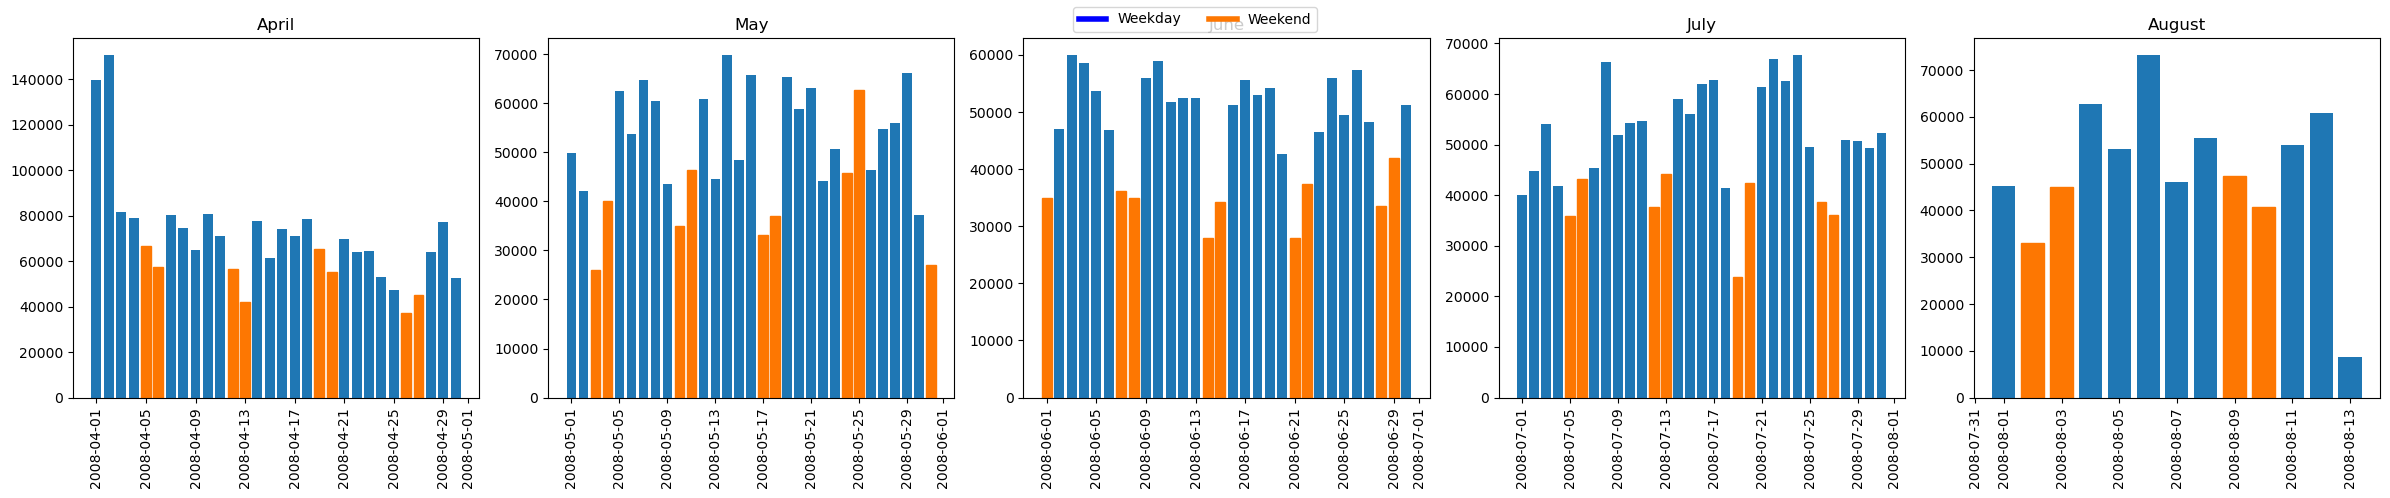

<Figure size 640x480 with 0 Axes>

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(24, 5))

for i, (start, end) in enumerate([(0, 30), (30, 61), (61, 91), (91, 122), (122, len(dfdate_revenue))]):
    bars = axs[i].bar(dfdate_revenue.index[start:end], dfdate_revenue.values[start:end])

    # Color weekends yellow
    for day, bar in zip(dfdate_revenue.index[start:end], bars):
        if day.weekday() >= 5: 
            bar.set_color('#FD7702')

    axs[i].set_title(dfdate_revenue.index[start].strftime('%B'))
    axs[i].tick_params(axis='x', rotation=90)

wd = plt.Line2D([0], [0], color='blue', lw=4)
we = plt.Line2D([0], [0], color='#FD7702', lw=4)

# Add legend to the plot
fig.legend([wd, we], ['Weekday', 'Weekend'], loc='upper center', ncol=2)
    
plt.tight_layout()
plt.show()
plt.savefig('date')

We can observe that sales are generally lower on weekends and higher on weekdays, so we can convert `date` into a binary variable `weekday`.

In [11]:
df['weekday'] = df['date'].apply(lambda x: 1 if x.weekday() < 5 else 0)
df.drop(['date'], axis = 1, inplace = True)

Now, we aim to reduce the number of categories under `country` and `colour`.

For `country`, note that most of the shop's transactions are based in Poland, so we will categorize them according to European regions. Those outside of Europe will be grouped under the international category while those that are unknown will be grouped under a single category as well.

We used the EuroVoc dictionary as a guide in categorizing the countries into four geographical regions in Europe. This list can be found on Wikipedia as the original dictionary has already been archived.

To extract the corresponding countries to the numbers in the dataset, we extracted the information from the `e-shop clothing 2008 data description.txt` file and used Excel to split the text easily. This was saved under `country_names.csv`.

Additionally, although Poland is the origin of the online shopping website, note that including the country greatly imbalances the dataset. Hence, for this study, we decided to focus on international transactions. After mapping the countries to the 6 regions, we dropped the rows that were tagged under Poland.

We also dropped the rows with unknown regions as it would be difficult to interpret these results later. Finally, we drop the `country` and `country_name` columns.

A similar approach was conducted on the `colour` column, where the colors were split into five types: light neutral, dark neutral, light-colored, dark-colored, and multi-colored garments.

In [12]:
df['country'].value_counts()

29    133963
9      18003
24      4091
46      2522
44      1385
16       834
21       811
34       716
41       684
3        256
27       227
12       210
42       170
37       163
10       152
31       144
22       144
28       139
38       137
15       125
11       115
25        71
2         58
32        49
23        46
14        43
39        34
43        31
19        29
17        23
36        19
18        18
20        10
7          9
47         7
45         6
6          5
30         5
5          4
33         3
1          3
35         3
13         2
26         2
40         1
4          1
8          1
Name: country, dtype: int64

In [13]:
# Mapping countries
country_names = pd.read_csv('country_names.csv', header = None)
country_names.rename(columns = {0 : 'original', 1: 'id', 2: 'country'}, inplace = True)
country_dict = country_names.set_index('id')['country'].to_dict()
df['country_name'] = df['country'].map(country_dict)

# The shop is based in Poland, so we will have more specific categorizations for Europe.
# This is based on the categorization on Wikipedia, which was extracted from the (now archived) EuroVoc dictionary.

central_eastern_europe = [
    'Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic',
    'Hungary', 'Kosovo', 'Montenegro', 'North Macedonia', 'Poland',
    'Romania', 'Serbia', 'Slovakia', 'Slovenia'
]

northern_europe = [
    'Estonia', 'Latvia', 'Lithuania', 'Denmark', 'Finland',
    'Iceland', 'Norway', 'Sweden', 'Faroe Islands',
]

southern_europe = [
    'Cyprus', 'Greece', 'Holy See', 'Italy', 'Malta',
    'Portugal', 'San Marino', 'Spain', 'Turkey'
]

western_europe = [
    'Andorra', 'Austria', 'Belgium', 'France', 'Germany',
    'Ireland', 'Liechtenstein', 'Luxeumbourg', 'Monaco', 'Netherlands',
    'Switzerland', 'United Kingdom'
]

# Estonia, Latvia, and Lithuania were categorized under both Central & Eastern Europe and Northern Europe in our source.
# The researchers opted to categorize them under Northern Europe.

cee_dict = {country : 1 for country in central_eastern_europe}
ne_dict = {country : 2 for country in northern_europe}
se_dict = {country : 3 for country in southern_europe}
we_dict = {country : 4 for country in western_europe}
europe_dict = {**cee_dict, **ne_dict, **se_dict, **we_dict}

unknown_loc = ['unidentified', 'biz (*.biz)', 'com (*.com)', 'int (*.int)', 'net (*.net)', 'org (*.org)']
unknown_dict = {idk : 6 for idk in unknown_loc}

region_dict = {**europe_dict, **unknown_dict}
df['region'] = df['country_name'].map(region_dict)
df['region'].fillna(5, inplace = True) # International
df['region'] = df['region'].astype(int)

# Hence, we have 1-4: European regions, 5: International, 6: Unknown.

# Dropping rows

# For this study, we will only consider transactions outside of Poland.
df = df[df['country_name'] != 'Poland']

# Region 6 will be dropped due to uninterpretability.
df = df[df['region'] != 6]

df.drop(['country', 'country_name'], axis = 1, inplace = True)

In [14]:
# Reducing the number of colour options

# Mapping colors
colour_names = pd.read_csv('colour_names.csv', header = None)
colour_names.rename(columns = {0 : 'original', 1: 'id', 2: 'colour'}, inplace = True)
colour_dict = colour_names.set_index('id')['colour'].to_dict()
df['colour_name'] = df['colour'].map(colour_dict)

# The categorization was inferred from the available colors in the online store.
# For instance, since there were options for "blue" and "navy blue", we assumed that blue was light-colored, since navy blue is a dark shade of blue.
# This inference was also conducted for green & olive and red & burgundy.

neutral_light = ['beige', 'gray', 'white']
neutral_dark = ['black', 'brown']
colored_light = ['blue', 'green', 'pink', 'red']
colored_dark = ['burgundy', 'navy blue', 'olive', 'violet']

nl_dict = {colour : 1 for colour in neutral_light}
nd_dict = {colour : 2 for colour in neutral_dark}
cl_dict = {colour : 3 for colour in colored_light}
cd_dict = {colour : 4 for colour in colored_dark}

colour_type_dict = {**nl_dict, **nd_dict, **cl_dict, **cd_dict}

df['colour_type'] = df['colour_name'].map(colour_type_dict)
df['colour_type'].fillna(5, inplace = True) # Multi-colored
df['colour_type'] = df['colour_type'].astype(int)

# Hence, we have 1-2: Neutrals, 3-4: Colored, 5: Multi-colored.

df.drop(['colour', 'colour_name'], axis = 1, inplace = True)

Next, we check for correlation. Note that we will first convert `product_code` into integers as we can observe that the first element of the string corresponds to the main category the product belongs to.

In [15]:
df['product_code'] = df['product_code'].apply(lambda x: int(re.search(r'\d+', x).group()))

<AxesSubplot:>

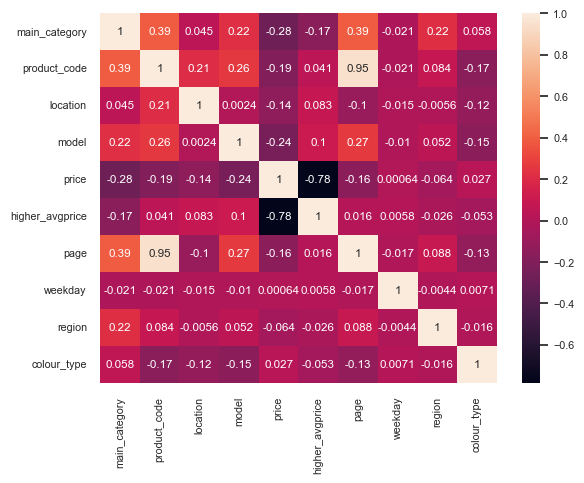

In [16]:
sns.set(font_scale=0.7)
sns.heatmap(df.corr(), annot=True)

We note that...
* `product_code` is highly correlated with `page`.
* `higher_avgprice` is highly correlated with `price`.
Hence, the former columns will be dropped.

In [17]:
df.drop(['product_code', 'higher_avgprice'], axis = 1, inplace = True)

Finally, we save the pre-processed dataset as a CSV file.

In [18]:
df

,main_category,location,model,price,page,weekday,region,colour_type
19,2,6,2,38,1,1,4,1
20,3,2,1,48,1,1,4,2
21,3,3,1,48,1,1,4,4
22,3,4,2,28,1,1,4,5
23,3,6,1,48,1,1,4,1
...,...,...,...,...,...,...,...,...
165221,3,1,2,33,4,1,1,4
165470,1,4,1,62,1,1,1,3
165471,1,1,1,43,1,1,1,3
165472,3,1,1,43,1,1,1,3


In [ ]:
df.to_csv('e-shop_processed.csv')

### Data Visualization

For the categorical data, we use bar plots in order to visualize the data distribution.

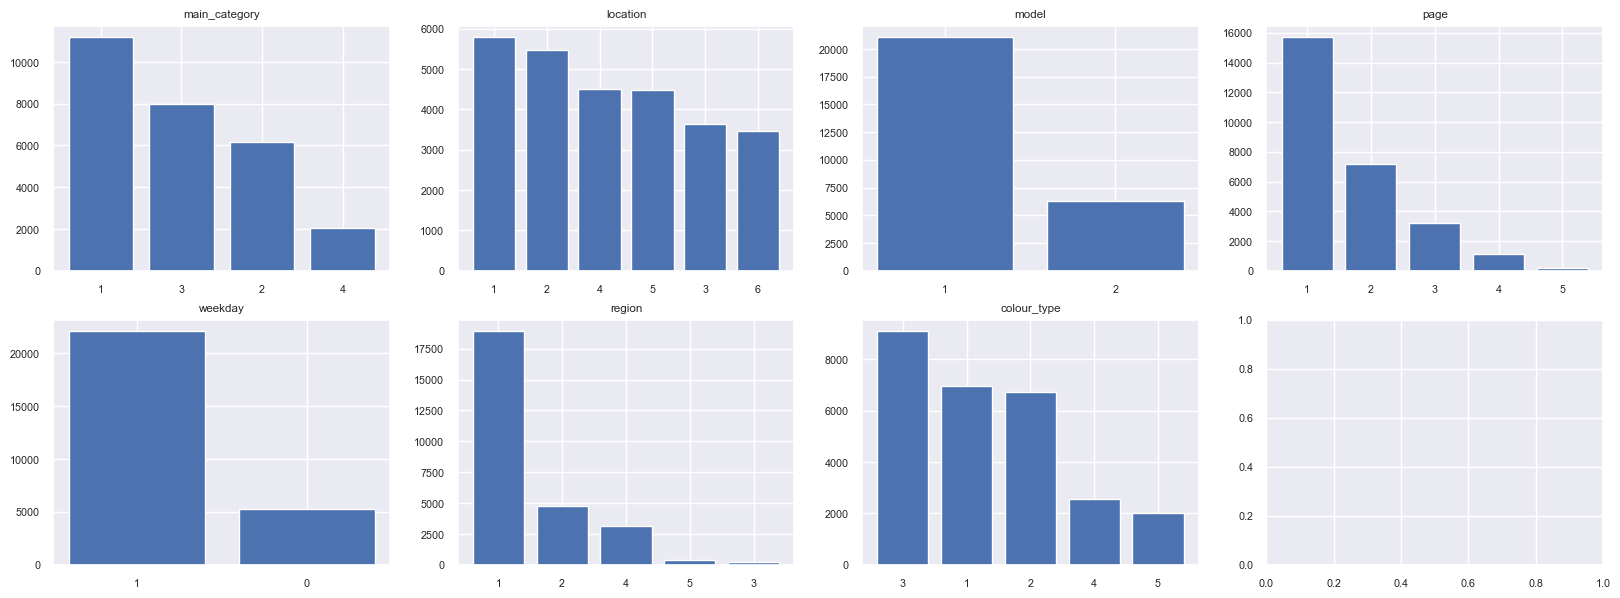

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(20, 7))

axs[0, 0].bar(df.iloc[:, 0].value_counts().index.astype(str), df.iloc[:, 0].value_counts().values)
axs[0, 0].set_title(df.columns[0])

axs[0, 1].bar(df.iloc[:, 1].value_counts().index.astype(str), df.iloc[:, 1].value_counts().values)
axs[0, 1].set_title(df.columns[1])

axs[0, 2].bar(df.iloc[:, 2].value_counts().index.astype(str), df.iloc[:, 2].value_counts().values)
axs[0, 2].set_title(df.columns[2])

axs[0, 3].bar(df.iloc[:, 4].value_counts().index.astype(str), df.iloc[:, 4].value_counts().values)
axs[0, 3].set_title(df.columns[4])

axs[1, 0].bar(df.iloc[:, 5].value_counts().index.astype(str), df.iloc[:, 5].value_counts().values)
axs[1, 0].set_title(df.columns[5])

axs[1, 1].bar(df.iloc[:, 6].value_counts().index.astype(str), df.iloc[:, 6].value_counts().values)
axs[1, 1].set_title(df.columns[6])

axs[1, 2].bar(df.iloc[:, 7].value_counts().index.astype(str), df.iloc[:, 7].value_counts().values)
axs[1, 2].set_title(df.columns[7])

plt.show()

### Initial EDA Insights

#### Most Clicked Location of Each Page
We first group the df by `page` then get the number of values of each `location`. We then use bar graphs to visualize the data.

In [21]:
dfpage = df.groupby('page')['location'].value_counts()
dfpage = dfpage.unstack(level=1)
dfpage

location,1,2,3,4,5,6
page,,,,,,
1,3141.0,3027.0,2199.0,2971.0,2305.0,2044.0
2,1292.0,1219.0,1032.0,1123.0,1480.0,1022.0
3,649.0,893.0,313.0,347.0,662.0,330.0
4,664.0,264.0,55.0,29.0,33.0,78.0
5,37.0,73.0,31.0,37.0,NaN,NaN


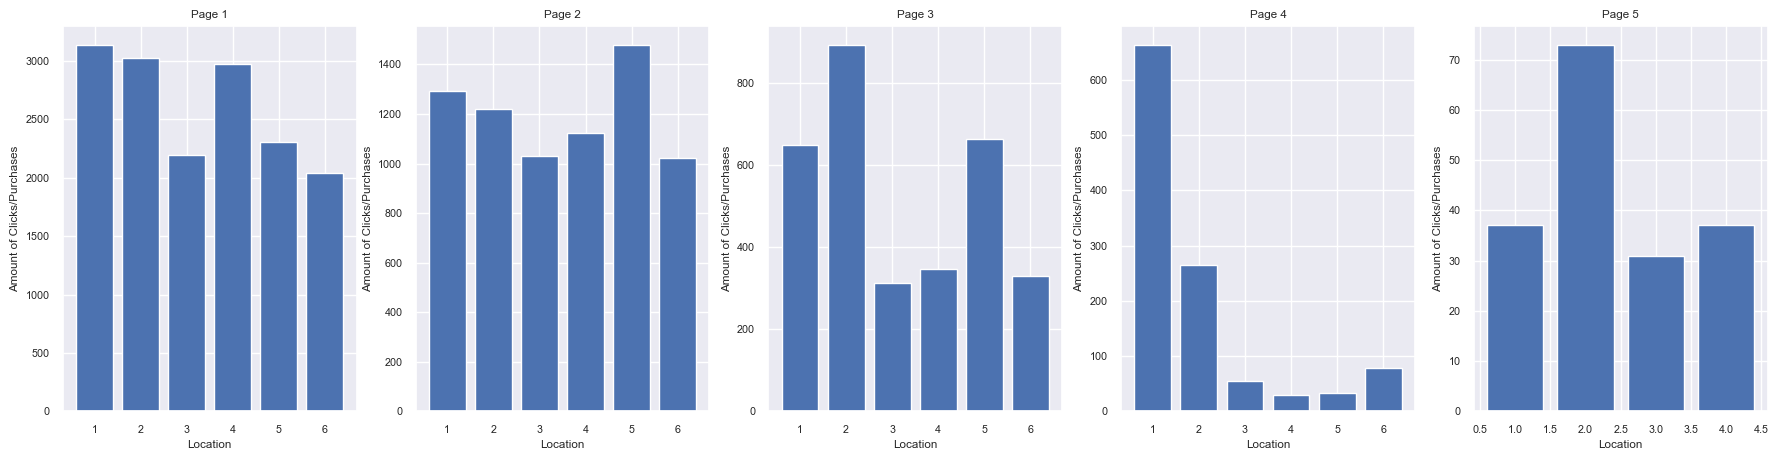

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(22, 5))
for i in np.arange(df['page'].nunique()):
    axs[i].bar(dfpage.iloc[i].index, dfpage.iloc[i].values)
    axs[i].set_title(f'Page {i+1}')
    axs[i].set_xlabel('Location')
    axs[i].set_ylabel('Amount of Clicks/Purchases')

- Page 1: Most purchases/clicks occur on locations 1, 2, and 4, which refer to the top left and middle and bottom left portions of the page.
- Page 2: Most purchases/clicks occur on location 5, which refers to the bottom middle portion of the page.
- Page 3: Most purchases/clicks occur on location 2, which refer to the top middle portion of the page.
- Page 4: Most purchases/clicks occur on location 1, which refer to the top left portion of the page.
- Page 5: Most purchases/clicks occur on location 2, which refers to the top middle portion of the page. It is also important to note that there are no instances for location 5-6, which refer to the bottom middle and right portion of the page.

#### Revenue per page
We group the df by `page` then get the sum of the prices in order to calculate the total revenue per `page`. Then we usea bar graph to visualize the data distribution.

In [25]:
dfpage_revenue = df.groupby('page')['price'].sum()
dfpage_revenue

page
1    729503
2    333060
3    118703
4     49547
5      7348
Name: price, dtype: int64

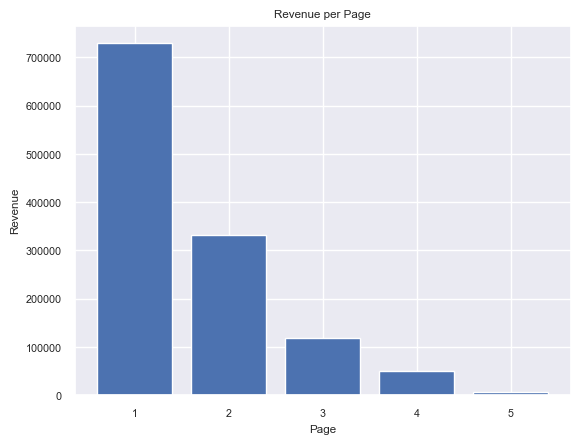

In [26]:
plt.bar(dfpage_revenue.index, dfpage_revenue.values)
plt.xlabel("Page")
plt.ylabel("Revenue")
plt.title("Revenue per Page")
plt.show()

We can observe a downward trend in revenue, with the most revenue being generated in Page 1.

#### Revenue per location per page
We group the df by `page` and `location` then get the sum of the prices in order to calculate the total revenue. Then we usea bar graph to visualize the data distribution.

In [28]:
dfpageloc_revenue = df.groupby(['page', 'location'])['price'].sum()
dfpageloc_revenue = dfpageloc_revenue.unstack(level=1)
dfpageloc_revenue

location,1,2,3,4,5,6
page,,,,,,
1,148517.0,135822.0,123636.0,136636.0,94300.0,90592.0
2,64915.0,56906.0,47015.0,52451.0,67315.0,44458.0
3,33625.0,28524.0,15281.0,10411.0,15539.0,15323.0
4,30418.0,12254.0,1585.0,1172.0,1334.0,2784.0
5,1221.0,3264.0,1087.0,1776.0,NaN,NaN


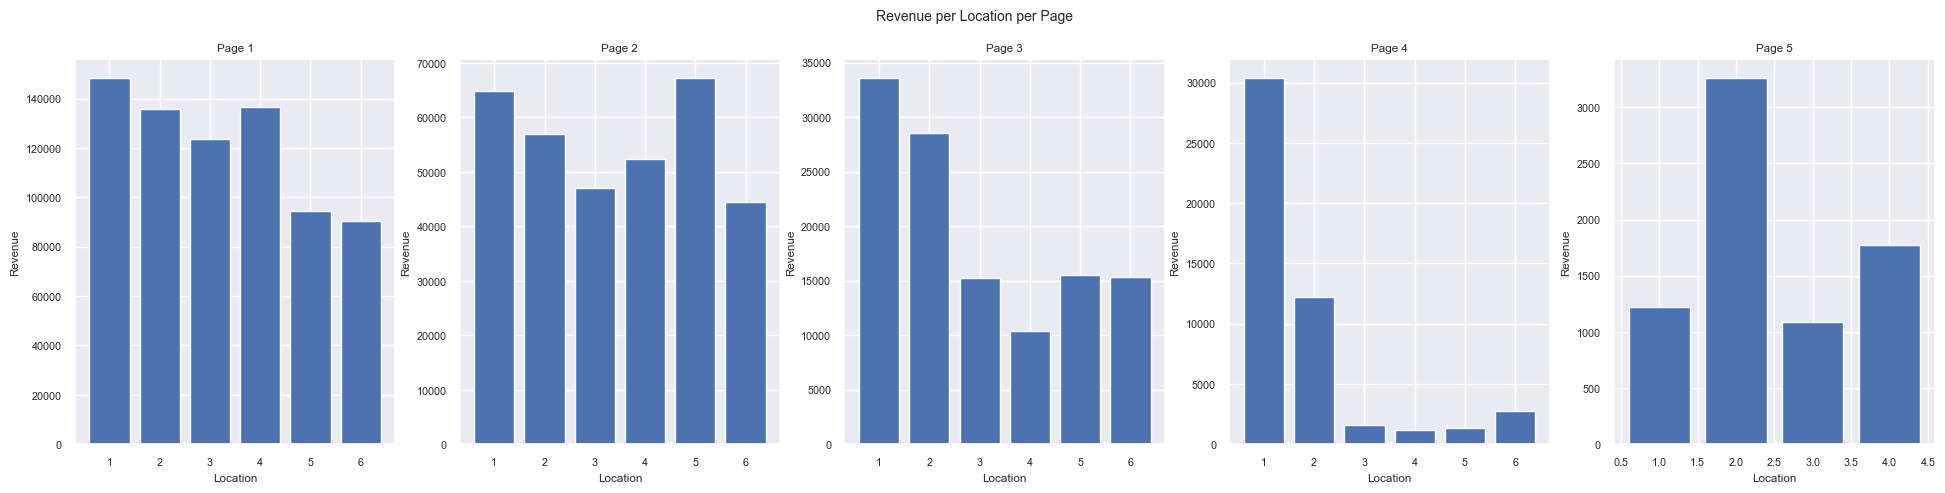

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(24, 5))
for i in np.arange(df['page'].nunique()):
    axs[i].bar(dfpageloc_revenue.iloc[i].index, dfpageloc_revenue.iloc[i].values)
    axs[i].set_title(f'Page {i+1}')
    axs[i].set_xlabel('Location')
    axs[i].set_ylabel('Revenue')
fig.suptitle("Revenue per Location per Page")
plt.show()

- Page 1: Most revenue is from locations 1-4, which refer to the top portion and bottom left portions of the page.
- Page 2: Most revenue is from locations 1 and 5, which refer to the top left and bottom middle portions of the page.
- Page 3: Most revenue is from location 1 (top left) followed by location 2 (top middle).
- Page 4: Most revenue is from location 1, which refers to the top left portion of the page.
- Page 5: Most revenue is from location 2, which refers to the top middle portion of the page. It is also important to note that there is no revenue generated location 5-6, which refer to the bottom middle and right portion of the page.

#### Revenue per Main Category
We group the df by `main_category` then get the sum of the prices in order to calculate the total revenue. Then we usea bar graph to visualize the data distribution.

In [60]:
dfcat_revenue = df.groupby('main_category')['price'].sum()
dfcat_revenue

main_category
1    530537
2    314535
3    318925
4     74164
Name: price, dtype: int64

Text(0, 0.5, 'Revenue')

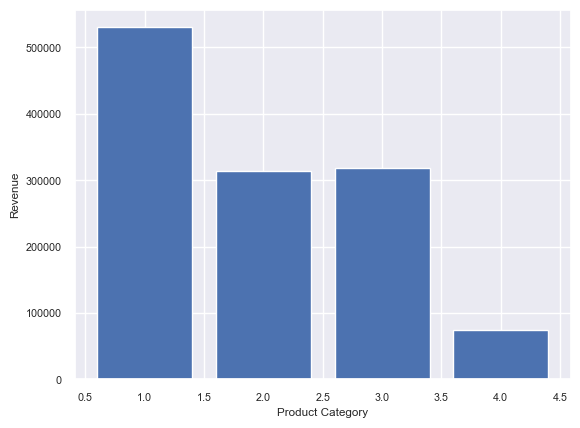

In [61]:
plt.bar(dfcat_revenue.index, dfcat_revenue.values)
plt.xlabel("Product Category")
plt.ylabel("Revenue")

We can observe a downward trend in revenue, with the most revenue being generated in Category 1, which refers to trousers.